# epitopepredict API basic usage

## Methodology

Predictors for each method inherit from the `Predictor` class and all implement a predict method for scoring a single sequence. This may wrap methods from other modules and/or call command line predictors. For example the `TepitopePredictor` uses the `mhcpredict.tepitope` module. This method should return a Pandas `DataFrame`. The `predictProteins` method is used for multiple proteins contained in a dataframe of sequences in a standard format. This is created from a genbank or fasta file (see examples below). For large numbers of sequences predictProteins you should provide a path so that the results are saved as each protein is completed to avoid memory issues, since many alleles might be called for each protein. Results are saved with one file per protein in csv format. Results can be loaded into the predictor individually or all together using the `load` method.

In [2]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
import epitopepredict as ep
from epitopepredict import base, sequtils, tepitope, plotting, utilities, peptutils, mhclearn
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt

In [3]:
#get preset alleles
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')
m1_alleles = ep.get_preset_alleles('mhc1_supertypes')
print (m1_alleles)
print (m2_alleles)

['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*03:01', 'HLA-A*24:02', 'HLA-B*07:02', 'HLA-B*44:03']
['HLA-DRB1*01:01', 'HLA-DRB1*03:01', 'HLA-DRB1*04:01', 'HLA-DRB1*07:01', 'HLA-DRB1*08:01', 'HLA-DRB1*11:01', 'HLA-DRB1*13:01', 'HLA-DRB1*15:01']


In [4]:
data = mhclearn.get_training_set('HLA-A*02:01')
data.length.value_counts()

9     9805
10    3806
11     141
8      110
12      15
15      12
13      12
14       9
16       5
20       4
18       2
7        1
21       1
17       1
Name: length, dtype: int64

## train models for basicmhc1 predictor before first use
this will be done automatically when you call the prediction methods if not run first

In [ ]:
reload(mhclearn)
mhclearn.train_models(overwrite=True, alleles=['H-2-Kb']#,'HLA-A*01:01','HLA-A*02:01','HLA-A*02:02','HLA-A*02:03','HLA-A*02:06'])

## predict random peptides

In [ ]:
reload(base)
reload(mhclearn)
seqs = peptutils.create_random_sequences(1000)
print (seqs[:5])
df = pd.DataFrame(seqs,columns=['peptide'])
P = base.get_predictor('basicmhc1')
b = P.predict_peptides(df.peptide, alleles=m1_alleles, cpus=8)

## results are returned as dataframes, sorted by score

In [21]:
print (b[:5])

     peptide  pos  log50k     score  name       allele  rank
0  CTDDVQIPF   50  0.7575     13.79  temp  HLA-A*01:01   1.0
1  ATAQFVWCF   92  0.2560   3133.53  temp  HLA-A*01:01   2.0
2  YRIILAMFY   86  0.2167   4794.06  temp  HLA-A*01:01   3.0
3  LLEDRVLPC   80  0.1501   9854.95  temp  HLA-A*01:01   4.0
4  LTCQEHLPP   27  0.1470  10191.11  temp  HLA-A*01:01   5.0


## predict from a sequence

In [25]:
seq = 'MTDDPGSGFTTVWNAVVSELNGDPKVDDGP'
b = P.predict_sequences(seq, alleles=m1_alleles, length=9)
b

predictions done for 1 sequences in 6 alleles


,allele,log50k,name,peptide,pos,rank,score
0,HLA-A*01:01,0.6209,0,MTDDPGSGFT,1,1.0,60.45
8,HLA-A*01:01,0.2287,0,FTTVWNAVVS,9,2.0,4210.32
12,HLA-A*01:01,0.1572,0,WNAVVSELNG,13,3.0,9126.24
16,HLA-A*01:01,0.1481,0,VSELNGDPKV,17,4.0,10070.54
18,HLA-A*01:01,0.1446,0,ELNGDPKVDD,19,5.0,10459.21
...,...,...,...,...,...,...,...
11,HLA-B*44:03,0.0136,0,VWNAVVSELN,12,17.0,43158.27
15,HLA-B*44:03,0.0102,0,VVSELNGDPK,16,18.0,44775.51
8,HLA-B*44:03,0.0066,0,FTTVWNAVVS,9,19.0,46553.98
4,HLA-B*44:03,0.0061,0,PGSGFTTVWN,5,20.0,46806.51


## predict n-mers from multiple protein sequence
This example loads protein sequences from mycobacterium tuberculosis from a genbank file

In [26]:
#load protein sequences into a dataframe
prots = ep.genbank_to_dataframe('../MTB-H37Rv.gb',cds=True)
prots[:5]

,type,protein_id,locus_tag,gene,db_xref,product,note,translation,pseudo,pseudogene,start,end,strand,length,order
2,CDS,CCP42723.1,Rv0001,dnaA,GI:444893470,Chromosomal replication initiator protein DnaA,"Rv0001, (MT0001, MTV029.01, P49993), len: 507 ...",MTDDPGSGFTTVWNAVVSELNGDPKVDDGPSSDANLSAPLTPQQRA...,NaN,NaN,0,1524,1,507,1
4,CDS,CCP42724.1,Rv0002,dnaN,GI:444893471,DNA polymerase III (beta chain) DnaN (DNA nucl...,"Rv0002, (MTV029.02, MTCY10H4.0), len: 402 aa. ...",MDAATTRVGLTDLTFRLLRESFADAVSWVAKNLPARPAVPVLSGVL...,NaN,NaN,2051,3260,1,402,2
6,CDS,CCP42725.1,Rv0003,recF,GI:444893472,DNA replication and repair protein RecF (singl...,"Rv0003, (MTCY10H4.01), len: 385 aa. RecF, DNA ...",MYVRHLGLRDFRSWACVDLELHPGRTVFVGPNGYGKTNLIEALWYS...,NaN,NaN,3279,4437,1,385,3
8,CDS,CCP42726.1,Rv0004,NaN,GI:444893473,Conserved hypothetical protein,"Rv0004, (MTCY10H4.02), len: 187 aa. Conserved ...",MTGSVDRPDQNRGERSMKSPGLDLVRRTLDEARAAARARGQDAGRG...,NaN,NaN,4433,4997,1,187,4
10,CDS,CCP42727.1,Rv0005,gyrB,GI:444893474,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,"Rv0005, (MTCY10H4.03), len: 675 aa. GyrB, DNA ...",MAAQKKKAQDEYGAASITILEGLEAVRKRPGMYIGSTGERGLHHLI...,NaN,NaN,5239,7267,1,675,5


In [27]:
P1 = ep.get_predictor('basicmhc1')
binders = P1.predict_sequences(prots[:10], alleles=m1_alleles, length=9, cpus=8)

took 15.461 seconds
predictions done for 10 sequences in 6 alleles


In [16]:
binders.head()

,allele,log50k,name,peptide,pos,rank,score
156,HLA-A*01:01,0.5139,Rv0001,NTDSATAGV,157,1.0,192.38
237,HLA-A*01:01,0.4559,Rv0001,STEEFTNDF,238,2.0,360.34
0,HLA-A*01:01,0.3769,Rv0001,MTDDPGSGF,1,3.0,847.09
466,HLA-A*01:01,0.3309,Rv0001,GRDHTTVMY,467,4.0,1393.42
261,HLA-A*01:01,0.2996,Rv0001,YRDVDVLLV,262,5.0,1955.05


## get promiscuous binders - those peptides above the cutoff for at least 3 alleles

In [10]:
pb1 = P1.promiscuous_binders(n=2)
pb1[:5]

,peptide,pos,name,alleles,core,score,mean,median_rank
423,WMITVAFLY,216,Rv0007,2,WMITVAFLY,93.59,676.810,1.5
204,LLDDVFAEL,323,Rv0003,2,LLDDVFAEL,5.20,2946.705,3.0
326,RVLTGVAAL,37,Rv0010c,2,RVLTGVAAL,72.97,270.835,3.5
247,MVLGQWSAV,97,Rv0004,2,MVLGQWSAV,70.26,778.570,4.0
288,RLAEHGAEL,189,Rv0003,2,RLAEHGAEL,21.39,53.515,4.5


## run other predictors

In [17]:
reload(base)
P2 = base.get_predictor('netmhcpan')
P2.predict_sequences(prots[:10], alleles=m1_alleles, length=9, cpus=10)

took 18.401 seconds
predictions done for 10 sequences in 6 alleles


,%Rank_BA,%Rank_EL,BindLevel,Gl,Gp,Icore,Identity,Il,Ip,Of,Score_BA,Score_EL,allele,core,ic50,name,peptide,pos,rank,score
0,0.177,0.091,<=,0,0,MTDDPGSGF,PEPLIST,0,0,0,0.486297,0.814747,HLA-A*01:01,MTDDPGSGF,259.34,Rv0001,MTDDPGSGF,0,1.0,259.34
156,0.325,0.771,<=,0,0,NTDSATAGV,PEPLIST,0,0,0,0.406686,0.195040,HLA-A*01:01,NTDSATAGV,613.71,Rv0001,NTDSATAGV,156,2.0,613.71
237,0.453,0.399,<=,0,0,STEEFTNDF,PEPLIST,0,0,0,0.364932,0.393147,HLA-A*01:01,STEEFTNDF,964.20,Rv0001,STEEFTNDF,237,3.0,964.20
326,0.454,0.255,<=,0,0,ITDVQPPEL,PEPLIST,0,0,0,0.364692,0.540838,HLA-A*01:01,ITDVQPPEL,966.70,Rv0001,ITDVQPPEL,326,4.0,966.70
453,0.649,0.920,<=,0,0,LTDLSLPKI,PEPLIST,0,0,0,0.316363,0.154183,HLA-A*01:01,LTDLSLPKI,1630.76,Rv0001,LTDLSLPKI,453,5.0,1630.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,90.887,49.500,NaN,0,0,DTPGRVLTG,PEPLIST,0,0,0,0.011297,0.000019,HLA-B*44:03,DTPGRVLTG,44247.20,Rv0010c,DTPGRVLTG,32,129.0,44247.20
82,94.208,85.000,NaN,0,0,NIKIIRIDE,PEPLIST,0,0,0,0.009862,0.000002,HLA-B*44:03,NIKIIRIDE,44939.55,Rv0010c,NIKIIRIDE,82,130.0,44939.55
34,95.248,95.000,NaN,0,0,PGRVLTGVA,PEPLIST,0,0,0,0.009047,0.000001,HLA-B*44:03,PGRVLTGVA,45337.60,Rv0010c,PGRVLTGVA,34,131.0,45337.60
122,95.389,85.000,NaN,0,0,PVEVLDALT,PEPLIST,0,0,0,0.008780,0.000002,HLA-B*44:03,PVEVLDALT,45468.75,Rv0010c,PVEVLDALT,122,132.0,45468.75


In [ ]:
reload(base)
P3 = base.get_predictor('mhcflurry')
P3.predict_sequences(prots[:10], alleles=m1_alleles, length=9, verbose=True)

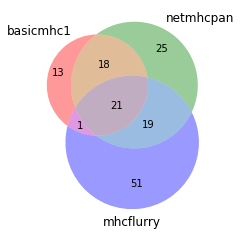

In [17]:
pb1 = P1.promiscuous_binders(n=2,cutoff=.93,limit=10)#,cutoff_method='rank')
pb2 = P2.promiscuous_binders(n=2,cutoff=.95,limit=10)#,cutoff_method='rank')
pb3 = P3.promiscuous_binders(n=2,cutoff=.95,limit=10)#,cutoff_method='rank')
from matplotlib_venn import venn3
ax = venn3((set(pb1.peptide),set(pb2.peptide),set(pb3.peptide)), set_labels = ('basicmhc1','netmhcpan','mhcflurry'))

## plot binders in a protein sequence

['Rv0001', 'Rv0002', 'Rv0003', 'Rv0004', 'Rv0005', 'Rv0006', 'Rv0007', 'Rv0008c', 'Rv0009', 'Rv0010c']


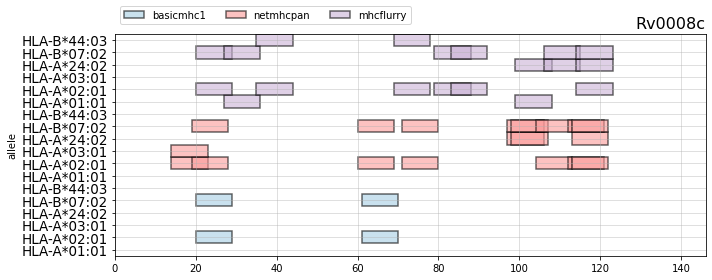

In [29]:
reload(plotting)
#get names of proteins stored in results of predictor
print (P2.get_names())
ax = plotting.plot_tracks([P1,P2,P3],name='Rv0008c',cutoff=.93,n=2,legend=True)
plt.tight_layout()
#plt.savefig('mhc_rv0011c.png',dpi=150)
#ax = plotting.plot_binder_map(P1,name='Rv0011c',cutoff=10)
#plt.savefig('mhc_rv0011c_map.png',dpi=150)

In [ ]:
reload(plotting)
from bokeh.io import show, output_notebook
output_notebook()
p = plotting.bokeh_plot_tracks([P1,P2],name='Rv0010c',cutoff=.96,n=3,width=800)
show(p)